### Library import

In [1]:
import os
import shutil
import subprocess
import argparse

#external  lib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from pycocotools.coco import COCO
from pprint import pprint
from skimage.color import rgb2gray

#local
import utils
import geometry.boundingBox as BBox
import geometry.geometry as geometry
import geometry.markovQBox as QBox


### Data loading

st: 0 edit list: 1 Missing key frame while searching for timestamp: 1000
st: 0 edit list 1 Cannot find an index entry before timestamp: 1000.
deprecated pixel format used, make sure you did set range correctly
st: 0 edit list: 1 Missing key frame while searching for timestamp: 1000
st: 0 edit list 1 Cannot find an index entry before timestamp: 1000.
deprecated pixel format used, make sure you did set range correctly


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


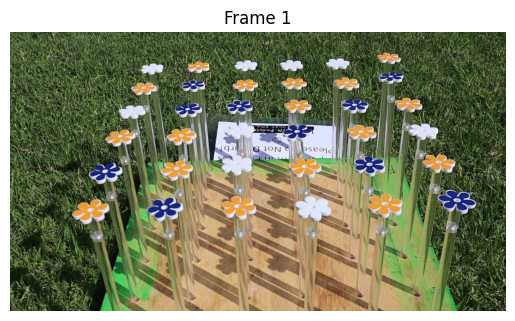

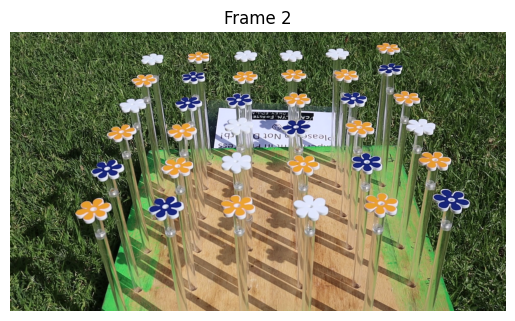

In [2]:
videoPath = 'C:\\GitHub\Bee-on-Artifical-Flower\\dataset\\video\\MVI_9183.MP4'

frameOne = utils.openVideoFrame(videoPath, 80)
frameTwo = utils.openVideoFrame(videoPath, 85)

dataDir='C:\\GitHub\\Bee-on-Artifical-Flower\\dataset\\BAF.v11i.coco\\train'
dataType='val2017'
annFile='C:\\GitHub\\Bee-on-Artifical-Flower\\dataset\BAF.v11i.coco\\train\\_annotations.coco.json'.format(dataDir,dataType)

coco=COCO(annFile)

plt.imshow(frameOne)
plt.axis('off')
plt.title('Frame 1')
plt.show()
plt.imshow(frameTwo)
plt.axis('off')
plt.title('Frame 2')
plt.show()

### coco dataset and normal representation of the flower

In [3]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
plastic-flower blue-flower orange-flower white-flower

COCO supercategories: 
plastic-flower none


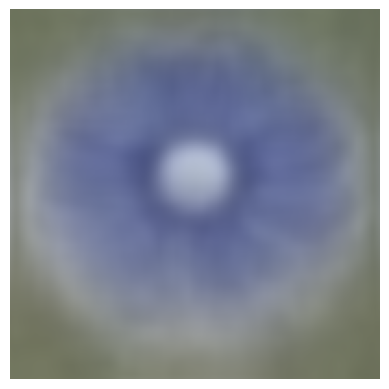

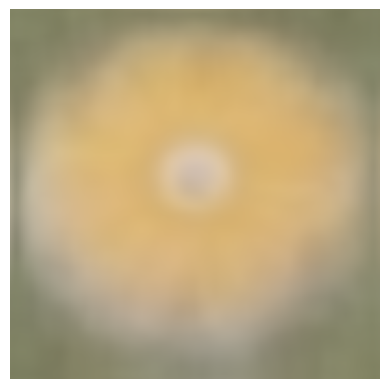

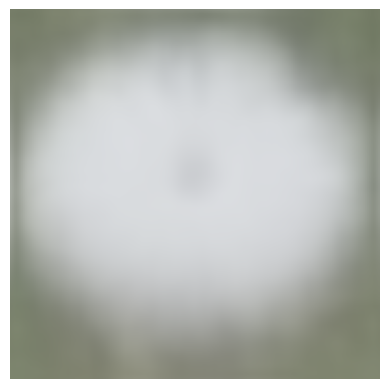

In [4]:
blueDemo = np.zeros((10,200,200,3))
orangeDemo = np.zeros((10,200,200,3))
whiteDemo = np.zeros((10,200,200,3))

blue = np.zeros((200,200,3))
orange = np.zeros((200,200,3))
white = np.zeros((200,200,3))

blueNb = 0
orangeNb = 0
whiteNb = 0

for i in range(0, 10):
    # get all images containing given categories, select one at random
    catIds = coco.getCatIds(catNms=['blue-flower','orange-flower','white-flower']);
    imgIds = coco.getImgIds(catIds=catIds )
    imgIds = coco.getImgIds(imgIds = [i])
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

    # load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    I = skimage.io.imread(dataDir + "\\" + img['file_name'])

    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    size = len(anns)

    for j in range(0,size):
        bbox = BBox.XYWHtominmaxXY(np.array([anns[j]['bbox']]))[0]

        crop = I[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

        crop = skimage.transform.resize(crop, (200,200))

        cat = anns[j]['category_id']
        
        if cat == 1:
            
            blueNb += 1
            blue += crop
            blueDemo[i%10] = crop
        if cat == 2:
            orangeNb += 1
            orange += crop
            orangeDemo[i%10]  = crop
        if cat == 3:
            whiteNb += 1
            white += crop
            whiteDemo[i%10]  = crop

        bbox = [bbox[2], bbox[1], bbox[0], bbox[1], bbox[0], bbox[3], bbox[2], bbox[3], bbox[2], bbox[1],]    
        anns[j]['segmentation'] = [bbox]

    # coco.showAnns(anns)
    # plt.show()


blue = blue/blueNb
orange = orange/orangeNb
white = white/whiteNb


plt.imshow(blue)
plt.axis('off')
plt.show()
plt.imshow(orange)
plt.axis('off')
plt.show()
plt.imshow(white)
plt.axis('off')
plt.show()

### HOG

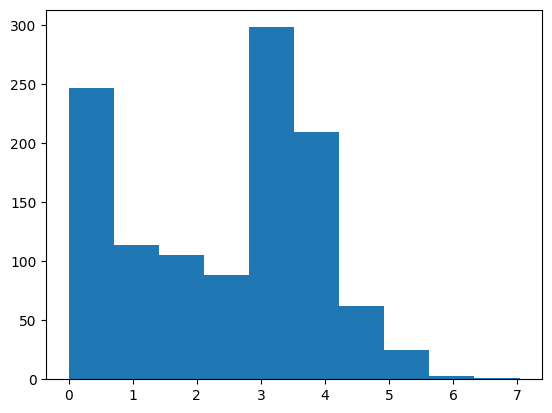

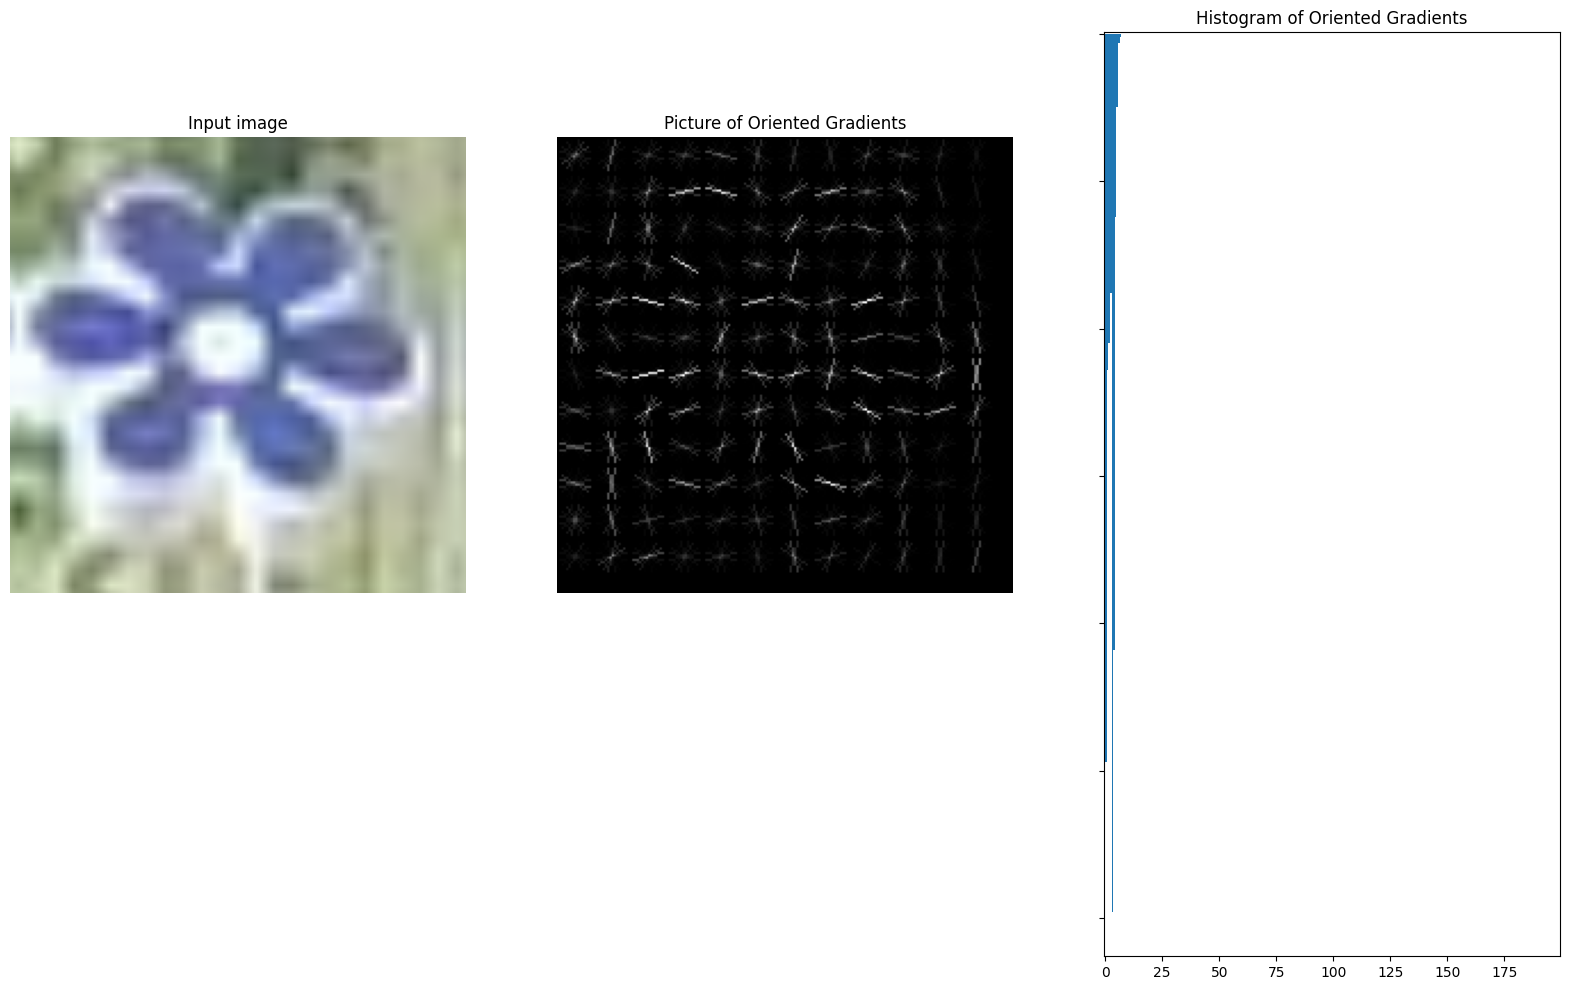

In [5]:
image = blueDemo[1]

fd, hog_image = skimage.feature.hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1, feature_vector=True)

plt.hist(fd*8)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12), sharex=True, sharey=True)




ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = skimage.exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Picture of Oriented Gradients')

ax3.hist(fd*8)
ax3.set_title('Histogram of Oriented Gradients')

plt.show()

### SIFT

In [6]:
import matplotlib.pyplot as plt

from skimage import transform
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage.transform import rescale

# img1 = rescale(rgb2gray(frameOne),0.5)
# img2 = rescale(rgb2gray(frameTwo),0.5)

img1 = rgb2gray(whiteDemo[7])
img2 = rgb2gray(whiteDemo[9])

descriptor_extractor = SIFT()

print("Descriptor 1")

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

print("Descriptor 2")

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

print("matching 1 and 2")

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=1.20,
                              cross_check=True)

Descriptor 1
Descriptor 2
matching 1 and 2


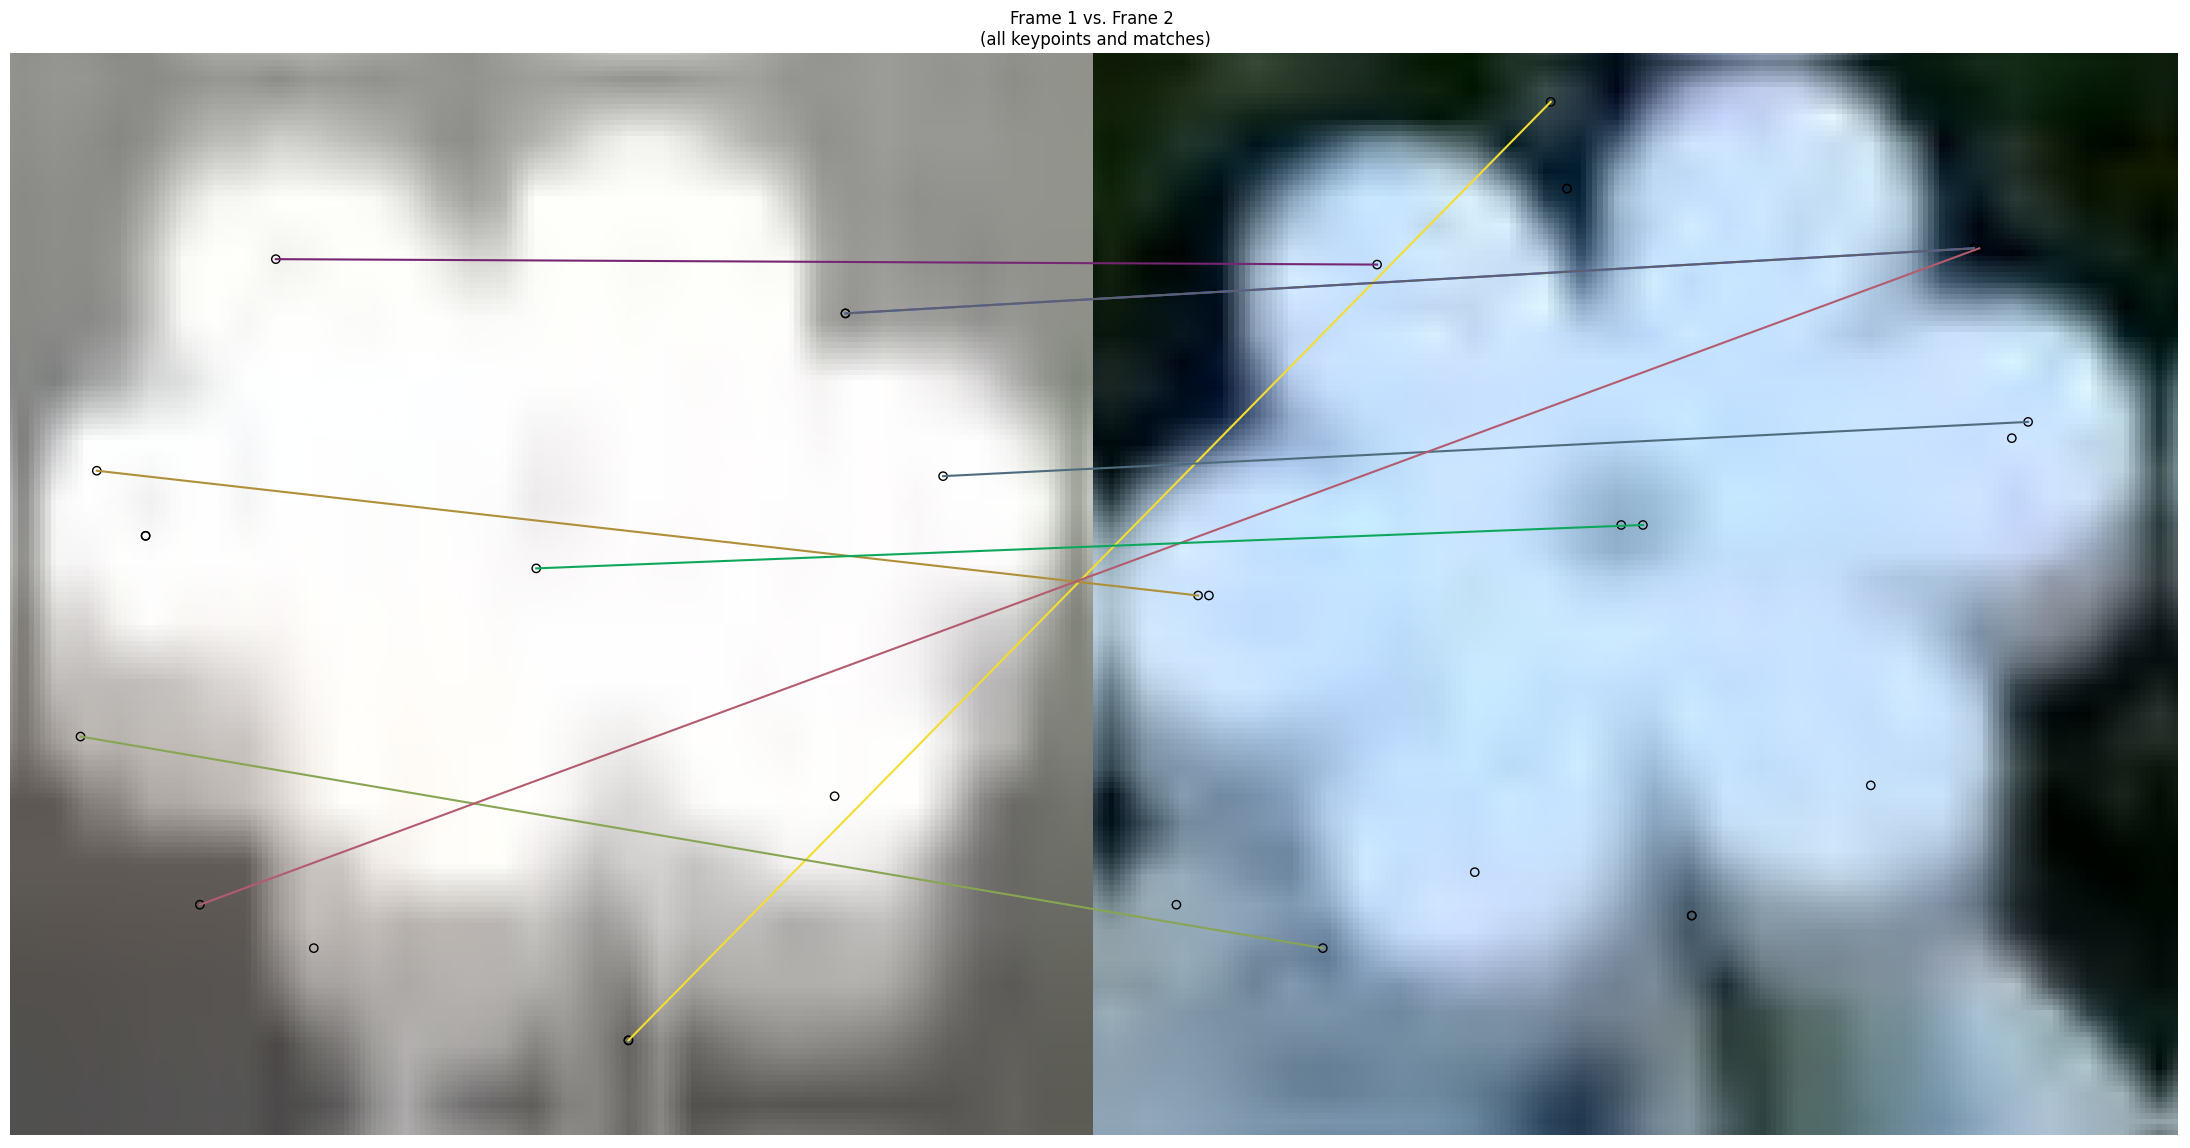

In [7]:
fig, ax = plt.subplots(1, figsize=(22, 12))

plt.gray()

plot_matches(ax, whiteDemo[7], whiteDemo[9], keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Frame 1 vs. Frane 2 \n"
                   "(all keypoints and matches)")

plt.tight_layout()
plt.show()